In [1]:
%load_ext autoreload
%autoreload 2
import HyperParam as hp
import AEhelper as ae
import tensorflow as tf
import pandas as pd
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import sklearn
 
from sklearn import preprocessing
from tensorflow import keras
from tensorflow.keras import optimizers
from pandas import DataFrame

pd.set_option("display.max_columns",200)

In [2]:
def load_train_data(dataset_path='D:/狠狠地干活/dataset/IDS2018/IDS2018/',traindata_file='Friday-23-02-2018_TrafficForML_CICFlowMeter.csv'):    
    #读取数据
    datatemp=pd.read_csv(dataset_path+traindata_file,index_col=False)
    #筛选所有非正常数据 ~label=Benign
    dataf=datatemp.loc[~datatemp['Label'].isin(['Benign'])]
    #筛选所有正常数据 label=Benign
    datatemp=datatemp.loc[datatemp['Label'].isin(['Benign'])]
    #print(datatemp['Label'].value_counts())
    datatemp=datatemp.reset_index(drop=True)
    dataf=dataf.reset_index(drop=True)
    
    data_afterdrop=datatemp.drop(columns=['Label','Timestamp'])
    dataf=dataf.drop(columns=['Label','Timestamp'])
    
    #data_standlize=data_afterdrop.apply(lambda x : (x-np.mean(x))/np.std(x))
    #dataf=dataf.applymap(lambda x : (x-np.mean(x))/np.std(x))
    
    data_normolize=data_afterdrop.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
    dataf=dataf.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
    
    data_normolize=data_normolize.fillna(0)
    dataf=dataf.fillna(0)
    
    print(data_normolize.shape,dataf.shape)
    
    return data_normolize,dataf


In [3]:
def label_change(x):
    if(x == 'Benign'):
        return False
    else:
        return True
        

In [4]:
def load_test_data(dataset_path='D:/狠狠地干活/dataset/IDS2018/IDS2018/',testdata_file='Friday-23-02-2018_TrafficForML_CICFlowMeter.csv'):
    #读取数据
    datatemp=pd.read_csv(dataset_path+testdata_file,index_col=False)
    datatemp=datatemp.reset_index(drop=True)
    #正常数据太多，只取200
    normal=datatemp.loc[datatemp['Label'].isin(['Benign'])]
    normal=normal.reset_index(drop=True)
    abnormal=datatemp.loc[~datatemp['Label'].isin(['Benign'])]
    abnormal=abnormal.reset_index(drop=True)
    s_normal=normal.sample(n=200)
    s_normal=s_normal.reset_index(drop=True)
    #拼接200个好数据和n个坏数据
    datatemp=pd.concat([s_normal,abnormal],axis=0)
    #打乱
    datatemp=datatemp.sample(frac=1)
    datatemp=datatemp.reset_index(drop=True)
    #标签和数据分离
    data_label=DataFrame(index=datatemp.index)
    data_label['Label']=datatemp['Label']
    data_label=data_label.applymap(label_change)
    
    data_afterdrop=datatemp.drop(columns=['Label','Timestamp'])
    #data_standlize=data_afterdrop.apply(lambda x : (x-np.mean(x))/np.std(x))
    data_normolize=data_afterdrop.apply(lambda x: (x-np.min(x))/(np.max(x)-np.min(x)))
    data_normolize=data_normolize.fillna(0)
    return data_normolize,data_label
    

In [36]:
temp,tempf=load_train_data()

xt=temp.sample(frac=0.8)
xv=tempf
"""xv=temp[~temp.index.isin(xt.index)]
xv=xv.reset_index(drop=True)
tempf=tempf.reset_index(drop=True)
print('before concat xv:',xv.shape)
xv=pd.concat([xv,tempf],axis=0)"""

print('xt:',xt.shape,'xv:',xv.shape)

(1048009, 78) (566, 78)
xt: (838407, 78) xv: (566, 78)


In [37]:
x_train=tf.convert_to_tensor(xt,dtype=tf.float32)
x_val=tf.convert_to_tensor(xv,dtype=tf.float32)
ds_train=tf.data.Dataset.from_tensor_slices((x_train,x_train)).shuffle(1312).batch(256)
ds_val=tf.data.Dataset.from_tensor_slices((x_val,x_val)).shuffle(1312).batch(256)

In [38]:
optimizer=optimizers.Adam(learning_rate=5e-4)

hparam=hp.hyperP(model_name='model.h5',
                 input_size=78,
                 layers=[100,64,32,16,8,4],
                 activation='relu',
                 dropout_rate=[0,0.1,0.1,0.2,0.2,0.2],
                 optimizer=optimizer,
                 loss='mae'
                 )
hparam.epochs=50
hparam.regularizer=0.01
model=ae.creat_model_1D(hparam)
history=ae.train(model=model,
                 ds_train=ds_train,
                 ds_val=ds_val,
                 hp=hparam,
            )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_78 (Dropout)         (None, 78)                0         
_________________________________________________________________
dense_86 (Dense)             (None, 100)               7900      
_________________________________________________________________
dropout_79 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 64)                6464      
_________________________________________________________________
dropout_80 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_81 (Dropout)         (None, 32)               

In [39]:
history.history['loss']
t=np.mean(history.history['loss'])
t2=np.std(history.history['loss'])
print(t,t2)

0.0519963800907135 0.010806007149157814


In [7]:
test_data,test_label=load_test_data(testdata_file='Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv')
#test_data.head(10)

In [41]:
test_label['Label'].value_counts()

True     362
False    200
Name: Label, dtype: int64

In [42]:
threshold,pred_data,sd=ae.find_best_threshold(train_loss=history.history['loss'],
                                 model=model,
                                 ds_data=test_data,
                                 ds_data_label=test_label,
                            )

start predict...
threshold test area:: [ 0.019578358643240062 , 0.08441440153818694 ] ,step: 0.0012967208578989376


100%|██████████| 50/50 [00:01<00:00, 33.92it/s, Accuracy=0.71352, Recall=1.00000, Precision=0.69216]

threshold: 0.02476524207483581


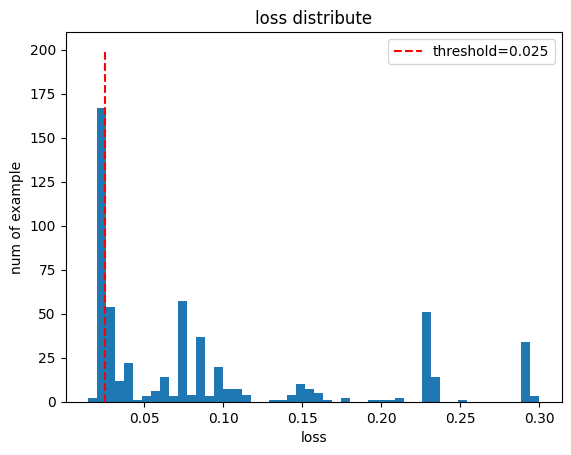

In [52]:
x=pred_data['Loss']
plt.title('loss distribute')
plt.xlabel('loss')
plt.ylabel('num of example')
plt.hist(x,bins=50)
plt.vlines(x=threshold,ymin=0,ymax=200,linestyles='dashed',colors='red',label='threshold='+'{0:1.3f}'.format(threshold))
plt.legend()
plt.show()

In [53]:
thresholds=[0.025,]

In [8]:
test_data_ii,test_label_ii=load_test_data(testdata_file='Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv')
test_label_ii['Label'].value_counts()

True     52498
False      200
Name: Label, dtype: int64

In [14]:
mod=tf.keras.models.load_model('autoencoder.h5')
predic=ae.test(mod,test_data_ii,test_label_ii)
sdd,score_test=ae.Assessment(0.025,predic)
print(score_test)

{'Accuracy': 0.8595961896087138, 'Recall': 0.8625280963084307, 'Precision': 0.9959967446055034}


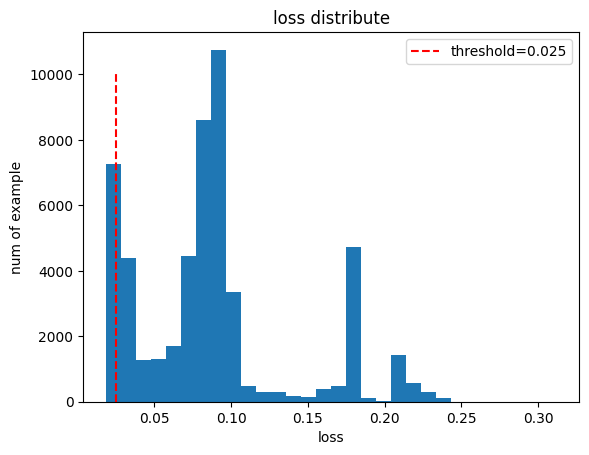

In [19]:
x=sdd['Loss']
plt.title('loss distribute')
plt.xlabel('loss')
plt.ylabel('num of example')
plt.hist(x,bins=30)
plt.vlines(x=0.025,ymin=0,ymax=10000,linestyles='dashed',colors='red',label='threshold='+'{0:1.3f}'.format(0.025))
plt.legend()
plt.show()